In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

### Loading in QA Data

In [2]:
# Load in question dataset 
df = pd.read_csv('qa_data\BEA_2024_MCQ_DIFF.csv')
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\B'
<>:2: SyntaxWarning: invalid escape sequence '\B'
C:\Users\ROHAN\AppData\Local\Temp\ipykernel_16520\299573397.py:2: SyntaxWarning: invalid escape sequence '\B'
  df = pd.read_csv('qa_data\BEA_2024_MCQ_DIFF.csv')


,ItemNum,ItemStem_Text,Answer__A,Answer__B,Answer__C,Answer__D,Answer__E,Answer__F,Answer__G,Answer__H,...,all_input,q_answers_input,answers_input,q_a_input,step_integer,Falcon_answer,Meditron_answer,Mistral_answer,llms_a_input,q_llms_a_input
0,622,A 27-year-old man comes to the emergency depar...,Choristoma,Ciliary epithelium,Endothelial cells,Gastric mucosa,Striated muscle,NaN,NaN,NaN,...,A 27-year-old man comes to the emergency depar...,A 27-year-old man comes to the emergency depar...,Choristoma. Ciliary epithelium. Endothelial ce...,A 27-year-old man comes to the emergency depar...,0,(A) Ciliary epithelium (B) Endothelial cells (C),EOD> .\nThe authors report a case of a 45-year...,/s>,(A) Ciliary epithelium (B) Endothelial cells (...,A 27-year-old man comes to the emergency depar...
1,440,"A 39-year-old woman, gravida 2, para 2, comes ...",Future fertility plans,Hypertension,Obesity,Patient age,Stage of disease,NaN,NaN,NaN,...,"A 39-year-old woman, gravida 2, para 2, comes ...","A 39-year-old woman, gravida 2, para 2, comes ...",Future fertility plans. Hypertension. Obesity....,"A 39-year-old woman, gravida 2, para 2, comes ...",2,The correct answer is C.\nThe correct answer i...,\n\n\nA. Future fertility plans\n\n\n\nB. Hype...,/s>,The correct answer is C. The correct answer is...,"A 39-year-old woman, gravida 2, para 2, comes ..."
2,12,An 18-year-old primigravid woman comes for her...,Repeat measurement of MSAFP concentration,"Triple screening for MSAFP, serum Î²-hCG, and ...",Ultrasonography,Amniocentesis for measurement of Î±-fetoprotei...,Amniocentesis for chromosomal analysis,NaN,NaN,NaN,...,An 18-year-old primigravid woman comes for her...,An 18-year-old primigravid woman comes for her...,Repeat measurement of MSAFP concentration. Tri...,An 18-year-old primigravid woman comes for her...,1,The correct answer is: C. Ultrasonography.\nTh...,\n## Answer:\nThe correct answer is option C. ...,\nThe correct answer is C. Ultrasonography.\n\...,The correct answer is: C. Ultrasonography. The...,An 18-year-old primigravid woman comes for her...
3,5,"A 26-year-old man, who is admitted to the hosp...",There is no evidence of a familial coagulation...,Half of their daughters will have a clinically...,The sons of their daughters will be at risk fo...,Their sons will be at risk for a clinically ev...,Their sons and daughters will be at risk for a...,NaN,NaN,NaN,...,"A 26-year-old man, who is admitted to the hosp...","A 26-year-old man, who is admitted to the hosp...",There is no evidence of a familial coagulation...,"A 26-year-old man, who is admitted to the hosp...",2,The answer is E.\nThe answer is E.\nThe answer...,\n## Answer:\nThe correct answer is option E. ...,\nThe correct answer is D.\n\nThe patient has ...,The answer is E. The answer is E. The answer i...,"A 26-year-old man, who is admitted to the hosp..."
4,221,A 60-year-old man had a total thyroidectomy an...,Babinski sign present bilaterally,Chvostek sign,Deviation of the tongue to the left side,A drooping left shoulder,Hyporeflexia,NaN,NaN,NaN,...,A 60-year-old man had a total thyroidectomy an...,A 60-year-old man had a total thyroidectomy an...,Babinski sign present bilaterally. Chvostek si...,A 60-year-old man had a total thyroidectomy an...,2,The correct answer is: C. Deviation of the ton...,\n\n\nA. Babinski sign present bilaterally\n\n...,\nThe correct answer is E. Hyporeflexia.\n\nTh...,The correct answer is: C. Deviation of the ton...,A 60-year-old man had a total thyroidectomy an...


In [3]:
# Function to format questions and answers while ignoring unwanted columns
def format_question(row):
    question = row["ItemStem_Text"]
    answers = []
    
    for col in sorted(row.index):
        if col.startswith("Answer_") and col not in ["Answer_Key", "Answer_Text"] and pd.notna(row[col]):  
            option = col[-1]  # Extract the last character (A, B, C, ...)
            answers.append(f"{option}) {row[col]}")
    
    return f"{question}\n\n" + "\n".join(answers)

# Apply function to each row
df["Formatted_Question"] = df.apply(format_question, axis=1)

# Print example output
print(df["Formatted_Question"][0])

A 27-year-old man comes to the emergency department because of a 3-hour history of pain around his navel. He also has had nausea and one episode of vomiting 1 hour ago. During the past year, he has had multiple episodes of dark stools, which last for 2 to 3 days and resolve spontaneously. He underwent an appendectomy 2 years ago. The patient says that his current symptoms are similar to those he had during the appendicitis episode. His temperature is 39.0Â°C (102.2Â°F), pulse is 94/min, respirations are 22/min, and blood pressure is 114/78 mm Hg. Pulse oximetry on room air shows an oxygen saturation of 99%. Physical examination shows rebound tenderness localized over the right lower quadrant. Results of laboratory studies are shown: Hemoglobin 12 g/dL Hematocrit 36% Leukocyte count 18,000/mm3 Platelet count 350,000/mm3 Serum Â  â€ƒUrea nitrogen 20 mg/dL â€ƒCreatinine 0.7 mg/dLCT scan of the abdomen shows fat stranding in the mesentery of the small bowel with an area of inflammation in 

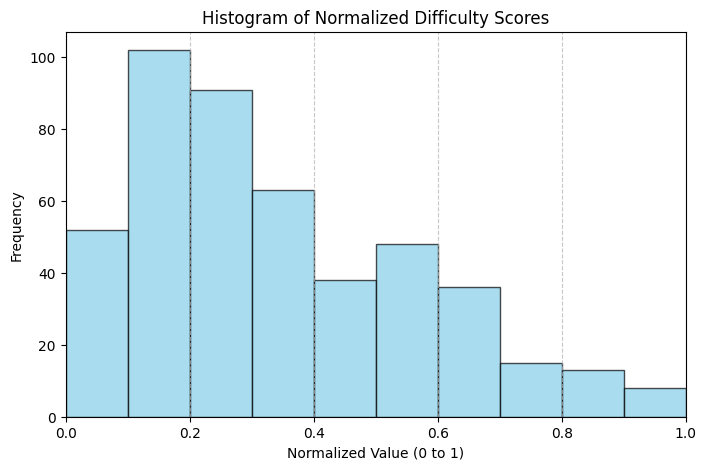

In [4]:
# Normalize difficulty
df['Difficulty'] = (df['Difficulty'] - df['Difficulty'].min()) / (df['Difficulty'].max() - df['Difficulty'].min())

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(df['Difficulty'], bins=10, color="skyblue", edgecolor="black", alpha=0.7)

# Labels and title
plt.xlabel("Normalized Value (0 to 1)")
plt.ylabel("Frequency")
plt.title("Histogram of Normalized Difficulty Scores")
plt.xlim(0, 1)  # Ensures x-axis stays in [0,1]
plt.grid(axis="x", linestyle="--", alpha=0.7)

### Running through all the Questions and storing think time.

In [5]:
from r1_overthink import reasoning_effort
import io
import contextlib
import json

In [6]:
OLLAMA_URL = "http://localhost:11434/api/generate"

In [7]:
# WORKING NONASYC CELL

results = []
df = df.iloc[0:100]
# Create a dummy output stream
# dummy_output = io.StringIO()

# with contextlib.redirect_stdout(dummy_output):
for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        question = row['Formatted_Question']

        response, num_think_tokens, num_swaps = reasoning_effort(question, model="deepseek-r1:1.5b", min_thinking_tokens=0) #Start by letting the model finish whenever it wants
        # correct = (row["Answer_Text"].lower() in answer.lower())
        results.append({
            "question": question,
            "difficulty": row["Difficulty"],
            "thinking_tokens": num_think_tokens,
            "num_swaps": num_swaps,
            "response": response,
            # "reasoning_trace": thoughts
        })
    except Exception as e:
        raise(e)
        continue

with open('natural_think_time2.json', 'w') as f:
    json.dump(results, f)

100%|██████████| 100/100 [1:02:25<00:00, 37.46s/it]


In [8]:
print(len(results))

100


In [9]:
print(results[0])

{'question': 'A 27-year-old man comes to the emergency department because of a 3-hour history of pain around his navel. He also has had nausea and one episode of vomiting 1 hour ago. During the past year, he has had multiple episodes of dark stools, which last for 2 to 3 days and resolve spontaneously. He underwent an appendectomy 2 years ago. The patient says that his current symptoms are similar to those he had during the appendicitis episode. His temperature is 39.0Â°C (102.2Â°F), pulse is 94/min, respirations are 22/min, and blood pressure is 114/78 mm Hg. Pulse oximetry on room air shows an oxygen saturation of 99%. Physical examination shows rebound tenderness localized over the right lower quadrant. Results of laboratory studies are shown: Hemoglobin 12 g/dL Hematocrit 36% Leukocyte count 18,000/mm3 Platelet count 350,000/mm3 Serum Â\xa0 â€ƒUrea nitrogen 20 mg/dL â€ƒCreatinine 0.7 mg/dLCT scan of the abdomen shows fat stranding in the mesentery of the small bowel with an area of

### Correlation Analysis

In [10]:
import re

# Function to extract answer letter
def extract_answer(text):
    if not isinstance(text, str):  # Handle NaN or non-string cases
        return ""
    match = re.search(r"\b([A-F])\b", text)  # Match A-F standalone
    return match.group(1) if match else ""

In [11]:
df['Answer_Text']

0                                        Gastric mucosa
1                                      Stage of disease
2                                       Ultrasonography
3     The sons of their daughters will be at risk fo...
4                                         Chvostek sign
                            ...                        
95                                  Hydrochlorothiazide
96                                         Constipation
97                                            DNA virus
98                                             Nystatin
99    Ketorolac 0.5% solution, 1 drop in right eye, ...
Name: Answer_Text, Length: 100, dtype: object

In [12]:
df['Answer_Key']

0     D
1     E
2     C
3     C
4     B
     ..
95    C
96    A
97    A
98    C
99    A
Name: Answer_Key, Length: 100, dtype: object

In [13]:
results_df = pd.DataFrame(results)

In [14]:
results_df.to_csv('deepseek-r1-1.5-tok0.csv')

In [15]:
def extract_answer(response_text):
    if "<answer>" in response_text:
        return response_text.split("<answer>")[-1].replace("</answer>", "")
    elif "Answer:" in response_text:
        return response_text.split("Answer:")[-1]
    elif "</think>" in response_text:
        return response_text.split("</think>")[-1]
    else:
        return response_text.split("\n\n")[-1]

In [16]:
results_df['cleaned_response'] = results_df['response'].apply(extract_answer)
df.rename(columns={'Formatted_Question': 'question'}, inplace=True)

# Merge df and results_df on the common key (adjust 'question_id' as needed)
merged_df = results_df.merge(df[['question', 'Answer_Key', 'Answer_Text']], on='question', how='left')

# Apply the logic row-wise
merged_df['correct'] = merged_df.apply(
    lambda row: (str(row['Answer_Key']) in str(row['cleaned_response'])) or 
                (str(row['Answer_Text']) in str(row['cleaned_response'])),
    axis=1
)


In [17]:
merged_df.head(30)

,question,difficulty,thinking_tokens,num_swaps,response,cleaned_response,Answer_Key,Answer_Text,correct
0,A 27-year-old man comes to the emergency depar...,0.264706,751,0,"<think>Okay, I'm trying to figure out what the...",A) Chor Obtuse isochores**,D,Gastric mucosa,False
1,"A 39-year-old woman, gravida 2, para 2, comes ...",0.352941,593,0,"<think>Okay, so I'm trying to figure out which...",D) Patient age,E,Stage of disease,False
2,An 18-year-old primigravid woman comes for her...,0.411765,751,0,"<think>Okay, so I'm trying to figure out the b...",B,C,Ultrasonography,False
3,"A 26-year-old man, who is admitted to the hosp...",0.397059,711,0,"<think>Alright, so I'm trying to figure out th...",A) There is no evidence of a familial coagula...,C,The sons of their daughters will be at risk fo...,False
4,A 60-year-old man had a total thyroidectomy an...,0.147059,3573,0,"<think>Alright, let me try to work through thi...",B,B,Chvostek sign,True
5,A 27-year-old man comes to the physician becau...,0.352941,1267,0,"<think>Okay, so I'm trying to figure out this ...",D) Hereditary hemorrhogenic telangiectasia,E,von Willebrand disease,False
6,A 55-year-old man has had crushing substernal ...,0.250000,649,0,"<think>Okay, so I'm trying to figure out the a...",{Decreasing myocardial contractility},A,Decreasing myocardial contractility,True
7,"In screening for prostate cancer, the current ...",0.455882,7243,0,"<think>Alright, so I'm trying to figure out th...",**\n\nLowering the decision threshold for reco...,G,â†“ â†‘,False
8,A 62-year-old man comes to the physician for a...,0.500000,609,0,"<think>Okay, so I'm trying to figure out this ...",G) â†“ â†“ â†‘,E,â†“ â†‘ â†‘,False
9,"A 37-year-old woman, gravida 5, para 4, at 34 ...",0.250000,777,0,"<think>Okay, so I need to figure out the most ...",C,D,Placenta previa,False


In [18]:
merged_df.correct.value_counts()

correct
False    72
True     28
Name: count, dtype: int64

                 difficulty  thinking_tokens
difficulty         1.000000         0.150905
thinking_tokens    0.150905         1.000000


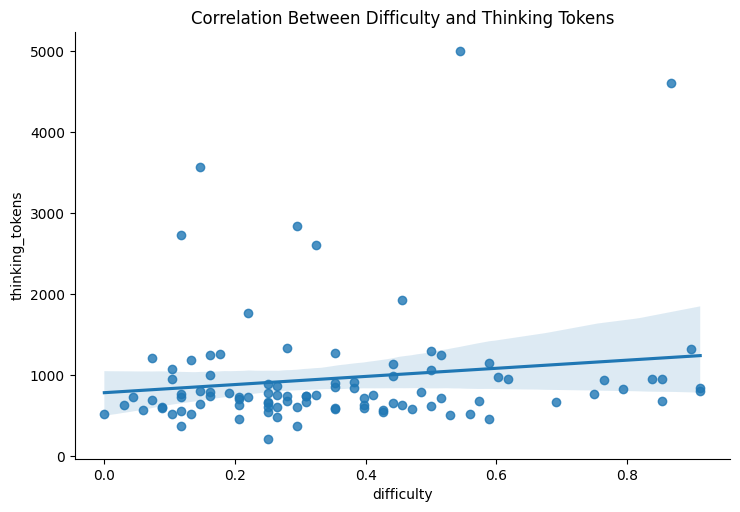

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute correlation
filtered_df = merged_df[merged_df['thinking_tokens'] <= 5000]
correlation = filtered_df[['difficulty', 'thinking_tokens']].corr()
print(correlation)

# Scatter plot with trendline
sns.lmplot(data=filtered_df, x='difficulty', y='thinking_tokens', aspect=1.5)
plt.title("Correlation Between Difficulty and Thinking Tokens")
plt.show()


C:\Users\ROHAN\AppData\Local\Temp\ipykernel_11940\3736686910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['correct_numeric'] = filtered_df['correct'].astype(int)


                 difficulty  correct_numeric
difficulty         1.000000         0.079168
correct_numeric    0.079168         1.000000


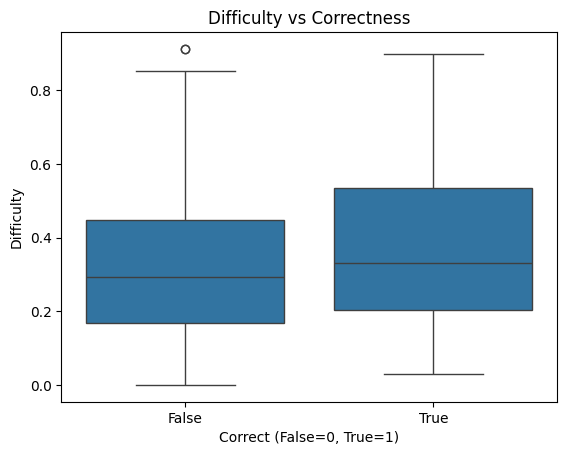

In [20]:
# Convert 'correct' column to numerical (False = 0, True = 1)
filtered_df['correct_numeric'] = filtered_df['correct'].astype(int)

# Compute correlation
correlation = filtered_df[['difficulty', 'correct_numeric']].corr()
print(correlation)

# Boxplot of difficulty vs correctness
sns.boxplot(data=filtered_df, x='correct', y='difficulty')
plt.title("Difficulty vs Correctness")
plt.xlabel("Correct (False=0, True=1)")
plt.ylabel("Difficulty")
plt.show()


### Now lets run with a finetuned r1 medical reasoning model and see if we get an increase in correlation or accuracy

In [8]:
# If above hasnt been run
df.rename(columns={'Formatted_Question': 'question'}, inplace=True)

In [22]:
from r1_overthink import reasoning_effort

In [23]:
df.columns

Index(['ItemNum', 'ItemStem_Text', 'Answer__A', 'Answer__B', 'Answer__C',
       'Answer__D', 'Answer__E', 'Answer__F', 'Answer__G', 'Answer__H',
       'Answer__I', 'Answer__J', 'Answer_Key', 'Answer_Text', 'ItemType',
       'EXAM', 'Difficulty', 'Response_Time', 'all_input', 'q_answers_input',
       'answers_input', 'q_a_input', 'step_integer', 'Falcon_answer',
       'Meditron_answer', 'Mistral_answer', 'llms_a_input', 'q_llms_a_input',
       'question'],
      dtype='object')

In [24]:
results = []
df = df.iloc[0:100]
# Create a dummy output stream
dummy_output = io.StringIO()

#with contextlib.redirect_stdout(dummy_output):
for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        question = row['question']
    
        response, num_think_tokens, num_swaps = reasoning_effort(question, "hf.co/ubiqtuitin/deepseek_r1_medical-ft_q4_k_m", min_thinking_tokens=0) #min should be 2k now.
        #correct = (row["Answer_Text"].lower() in answer.lower())
        results.append({
            "question": question,
            "difficulty": row["Difficulty"],
            "thinking_tokens": num_think_tokens,
            "num_swaps": num_swaps,
            "response": response,
            # "reasoning_trace": thoughts
        })
    except Exception as e:
        raise(e)
        continue

with open('natural_think_time3.json', 'w') as f:
    json.dump(results, f)

100%|██████████| 100/100 [1:25:23<00:00, 51.23s/it]


In [25]:
print(len(results))

100


In [26]:
print(results[0])

{'question': 'A 27-year-old man comes to the emergency department because of a 3-hour history of pain around his navel. He also has had nausea and one episode of vomiting 1 hour ago. During the past year, he has had multiple episodes of dark stools, which last for 2 to 3 days and resolve spontaneously. He underwent an appendectomy 2 years ago. The patient says that his current symptoms are similar to those he had during the appendicitis episode. His temperature is 39.0Â°C (102.2Â°F), pulse is 94/min, respirations are 22/min, and blood pressure is 114/78 mm Hg. Pulse oximetry on room air shows an oxygen saturation of 99%. Physical examination shows rebound tenderness localized over the right lower quadrant. Results of laboratory studies are shown: Hemoglobin 12 g/dL Hematocrit 36% Leukocyte count 18,000/mm3 Platelet count 350,000/mm3 Serum Â\xa0 â€ƒUrea nitrogen 20 mg/dL â€ƒCreatinine 0.7 mg/dLCT scan of the abdomen shows fat stranding in the mesentery of the small bowel with an area of

In [27]:
results_df = pd.DataFrame(results)
results_df.to_csv('ubitquitin_medical_deepseek-1.5-tok0.csv')

In [28]:
def extract_answer(response_text):
    if "<answer>" in response_text:
        return response_text.split("<answer>")[-1].replace("</answer>", "")
    elif "Answer:" in response_text:
        return response_text.split("Answer:")[-1]
    elif "</think>" in response_text:
        return response_text.split("</think>")[-1]
    else:
        return response_text.split("\n\n")[-1]

In [29]:
results_df['cleaned_response'] = results_df['response'].apply(extract_answer)
df.rename(columns={'Formatted_Question': 'question'}, inplace=True)

# Merge df and results_df on the common key (adjust 'question_id' as needed)
merged_df = results_df.merge(df[['question', 'Answer_Key', 'Answer_Text']], on='question', how='left')

# Apply the logic row-wise
merged_df['correct'] = merged_df.apply(
    lambda row: (str(row['Answer_Key']) in str(row['cleaned_response'])) or 
                (str(row['Answer_Text']) in str(row['cleaned_response'])),
    axis=1
)


In [30]:
merged_df['response'].iloc[1]

"<think>Okay, let's break down this problem step by step to figure out what it's asking and how we can solve it. The user is providing a medical case for a39-year-old woman with an abnormal Pap smear in her mid-20s and some other symptoms. We need to determine the most critical factor in formulating a management plan based on this patient's description.\n\nFirst, let me understand the patient's presenting information:\n\n1. **Age**: She is39 years old.\n2. **Dysfunctional Symptoms**: She reports spotting that began6 months ago and has progressed to heavy bleeding over the past3 weeks.\n3. **Physical Profile**: It’s important to note her BMI, age, and vital signs:\n - BMI:32 kg/m² - Temperature:37.2°C (99.0°F)\n - Pulse:90 beats per minute - Respirations:14 breaths per minute - Blood Pressure:155/96 mmHgShe's married for16 years and her husband died4 years ago after having a vasectomy. This suggests that she might have had some medical history related to this.\n\nNow, looking at the opt

In [31]:
merged_df.head(30)

,question,difficulty,thinking_tokens,num_swaps,response,cleaned_response,Answer_Key,Answer_Text,correct
0,A 27-year-old man comes to the emergency depar...,0.264706,4378,0,"<think>Okay, let me try to figure out what's g...","E.\n\nWait, but isn't it more about strain ch...",D,Gastric mucosa,False
1,"A 39-year-old woman, gravida 2, para 2, comes ...",0.352941,1022,0,"<think>Okay, let's break down this problem ste...",The most critical factor in formulating a mana...,E,Stage of disease,False
2,An 18-year-old primigravid woman comes for her...,0.411765,477,0,"<think>Alright, let's tackle this question. So...",D) Amniocentesis for chromosomal analysis,C,Ultrasonography,False
3,"A 26-year-old man, who is admitted to the hosp...",0.397059,736,0,"<think>Okay, so I've got this medical case to ...","Based on the scenario provided, the most appro...",C,The sons of their daughters will be at risk fo...,False
4,A 60-year-old man had a total thyroidectomy an...,0.147059,1232,0,"<think>Okay, let's try to figure this out. So ...",E) Hyporeflexia**,B,Chvostek sign,False
5,A 27-year-old man comes to the physician becau...,0.352941,871,0,"<think>Alright, so I'm trying to figure out wh...",C) Hemophilia A,E,von Willebrand disease,False
6,A 55-year-old man has had crushing substernal ...,0.250000,2483,0,"<think>Okay, so I have this question about a m...",The primary issue here is a build-up in airway...,A,Decreasing myocardial contractility,True
7,"In screening for prostate cancer, the current ...",0.455882,20404,0,"<think>Alright, let's try to figure this out. ...",\n- TR refers to **True Positive Rate** (sensi...,G,â†“ â†‘,False
8,A 62-year-old man comes to the physician for a...,0.500000,903,0,"<think>Alright, so I'm looking at this questio...",The correct answer is **C) â†‘â†“â†‘**.### Ste...,E,â†“ â†‘ â†‘,True
9,"A 37-year-old woman, gravida 5, para 4, at 34 ...",0.250000,606,0,"<think>Alright, let me figure out this case. S...",The most likely diagnosis in this case is **a ...,D,Placenta previa,False


In [32]:
merged_df.iloc[10]['response']

"<think>Okay, let me try to figure out what's going on here. So we have a2-year-old boy who's seen an issue in two areas: his health isn't improving and he's had some bacterial growth problems because of the hyperinflation. That means there's something inflamed in his lungs or perhaps the heart might be affected, leading to inflammation. The fact that it's called hyperinflation suggests maybe a inflammatory response.\n\nHe also has loose, fatty, foul-smelling stools. Foul-smelling could mean something like iritis, which is usually caused by bacteria. So we're looking at ulcers here. His appearance is still normal except for his height and weight percentages, so he's in the30th percentile for height and10th percentile for weight. That means he’s on the lower side in height and upper end of weight.\n\nLooking into the labs: there's steatorrhea and a high sweat chloride. Steatorrhea is related to iron deficiency, which could cause inflammation like ulcers. High sweat chloride indicates th

In [33]:
merged_df.iloc[10]

question            A 2-year-old boy is brought to the physician b...
difficulty                                                   0.279412
thinking_tokens                                                  1316
num_swaps                                                           0
response            <think>Okay, let me try to figure out what's g...
cleaned_response    The patient presents with symptoms of ulcers, ...
Answer_Key                                                          A
Answer_Text                                               Bicarbonate
correct                                                         False
Name: 10, dtype: object

In [34]:
merged_df.correct.value_counts()

correct
False    61
True     39
Name: count, dtype: int64

                 difficulty  thinking_tokens
difficulty         1.000000        -0.032982
thinking_tokens   -0.032982         1.000000


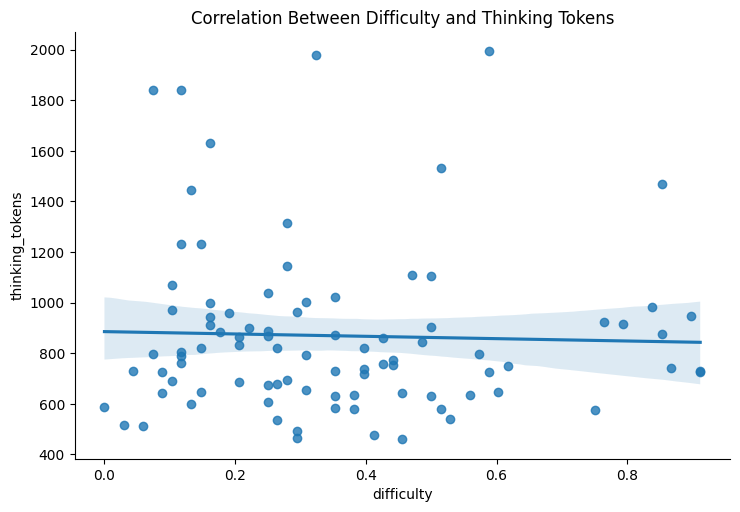

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute correlation
filtered_df = merged_df[merged_df['thinking_tokens'] <= 2000]
correlation = filtered_df[['difficulty', 'thinking_tokens']].corr()
print(correlation)

# Scatter plot with trendline
sns.lmplot(data=filtered_df, x='difficulty', y='thinking_tokens', aspect=1.5)
plt.title("Correlation Between Difficulty and Thinking Tokens")
plt.show()


C:\Users\ROHAN\AppData\Local\Temp\ipykernel_11940\3736686910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['correct_numeric'] = filtered_df['correct'].astype(int)


                 difficulty  correct_numeric
difficulty         1.000000         0.126998
correct_numeric    0.126998         1.000000


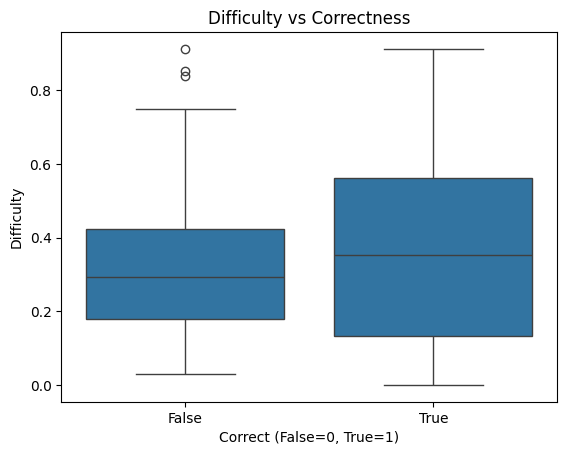

In [36]:
# Convert 'correct' column to numerical (False = 0, True = 1)
filtered_df['correct_numeric'] = filtered_df['correct'].astype(int)

# Compute correlation
correlation = filtered_df[['difficulty', 'correct_numeric']].corr()
print(correlation)

# Boxplot of difficulty vs correctness
sns.boxplot(data=filtered_df, x='correct', y='difficulty')
plt.title("Difficulty vs Correctness")
plt.xlabel("Correct (False=0, True=1)")
plt.ylabel("Difficulty")
plt.show()


### Now lets run with at least 2k tokens per call

In [37]:
results = []
df = df.iloc[0:100]
# Create a dummy output stream
dummy_output = io.StringIO()

#with contextlib.redirect_stdout(dummy_output):
for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        question = row['question']
    
        response, num_think_tokens, num_swaps = reasoning_effort(question, "hf.co/ubiqtuitin/deepseek_r1_medical-ft_q4_k_m", min_thinking_tokens=2000) #min should be 2k now.
        #correct = (row["Answer_Text"].lower() in answer.lower())
        results.append({
            "question": question,
            "difficulty": row["Difficulty"],
            "thinking_tokens": num_think_tokens,
            "num_swaps": num_swaps,
            "response": response,
            # "reasoning_trace": thoughts
        })
    except Exception as e:
        raise(e)
        continue

with open('natural_think_time3.json', 'w') as f:
    json.dump(results, f)

100%|██████████| 100/100 [1:01:06<00:00, 36.66s/it]


In [38]:
print(len(results))

100


In [39]:
print(results[0])

{'question': 'A 27-year-old man comes to the emergency department because of a 3-hour history of pain around his navel. He also has had nausea and one episode of vomiting 1 hour ago. During the past year, he has had multiple episodes of dark stools, which last for 2 to 3 days and resolve spontaneously. He underwent an appendectomy 2 years ago. The patient says that his current symptoms are similar to those he had during the appendicitis episode. His temperature is 39.0Â°C (102.2Â°F), pulse is 94/min, respirations are 22/min, and blood pressure is 114/78 mm Hg. Pulse oximetry on room air shows an oxygen saturation of 99%. Physical examination shows rebound tenderness localized over the right lower quadrant. Results of laboratory studies are shown: Hemoglobin 12 g/dL Hematocrit 36% Leukocyte count 18,000/mm3 Platelet count 350,000/mm3 Serum Â\xa0 â€ƒUrea nitrogen 20 mg/dL â€ƒCreatinine 0.7 mg/dLCT scan of the abdomen shows fat stranding in the mesentery of the small bowel with an area of

In [40]:
results_df = pd.DataFrame(results)
results_df.to_csv('ubitquitin_medical_deepseek-1.5-tok2000.csv')

In [41]:
def extract_answer(response_text):
    if "<answer>" in response_text:
        return response_text.split("<answer>")[-1].replace("</answer>", "")
    elif "Answer:" in response_text:
        return response_text.split("Answer:")[-1]
    elif "</think>" in response_text:
        return response_text.split("</think>")[-1]
    else:
        return response_text.split("\n\n")[-1]

In [42]:
results_df['cleaned_response'] = results_df['response'].apply(extract_answer)
df.rename(columns={'Formatted_Question': 'question'}, inplace=True)

# Merge df and results_df on the common key (adjust 'question_id' as needed)
merged_df = results_df.merge(df[['question', 'Answer_Key', 'Answer_Text']], on='question', how='left')

# Apply the logic row-wise
merged_df['correct'] = merged_df.apply(
    lambda row: (str(row['Answer_Key']) in str(row['cleaned_response'])) or 
                (str(row['Answer_Text']) in str(row['cleaned_response'])),
    axis=1
)


In [43]:
merged_df['response'].iloc[1]

"<think>\nWait,Alright, let's break down this problem step by step to figure out what’s going on.\nAlternatively,So, there's a\nHmm,39-year-old woman with some pretty concerning health issues. She has been experiencing\nAlternatively,6 months of copious, foul-smelling vaginal discharge since her marriage ended\nWait,4 years ago. Plus, she’s seeing a lot more bleeding, especially now for the past three weeks. That seems like it could be an issue.\n\nShe mentions there was an abnormal Pap smear in her\nWait,20s and took no medications. Her husband died before, so she had that vasectomy. Now, she hasn't had any new partners since then.\n\nHer medical history includes a significant risk of having a Pap smear in her\nAlternatively,20s; this started way back when she was in her second pregnancy. The results were normal, though, which is interesting because it might mean she's not having those early symptoms often.\n\nLooking at the patient's clinical data: she has BMI of\nHmm,32 kg/m² and no

In [44]:
merged_df.head(30)

,question,difficulty,thinking_tokens,num_swaps,response,cleaned_response,Answer_Key,Answer_Text,correct
0,A 27-year-old man comes to the emergency depar...,0.264706,555,13,"<think>\nAlternatively,Okay, so I'm trying to ...","Thus, the most likely pathological finding is ...",D,Gastric mucosa,False
1,"A 39-year-old woman, gravida 2, para 2, comes ...",0.352941,1012,21,"<think>\nWait,Alright, let's break down this p...","\nWait,: D) Patient age\nHmm,",E,Stage of disease,False
2,An 18-year-old primigravid woman comes for her...,0.411765,431,11,"<think>\nAlternatively,Alright, let's see. We ...","Wait,\nHmm,B) Triple screening for MSAFP, seru...",C,Ultrasonography,True
3,"A 26-year-old man, who is admitted to the hosp...",0.397059,700,12,"<think>\nAlternatively,Okay, so I need to figu...","Alternatively,\nWait,Their sons will be at ris...",C,The sons of their daughters will be at risk fo...,False
4,A 60-year-old man had a total thyroidectomy an...,0.147059,929,14,"<think>\nWait,Okay, let's break down this ques...","**\nAlternatively,: E) Hyporeflexia**\nAlterna...",B,Chvostek sign,False
5,A 27-year-old man comes to the physician becau...,0.352941,850,18,"<think>\nWait,Alright, let's figure this out. ...","\nAlternatively,: E) von Willebrand disease\nW...",E,von Willebrand disease,True
6,A 55-year-old man has had crushing substernal ...,0.250000,531,8,"<think>\nWait,Okay, so I have this question ab...","Wait,\nWait,A) Decreasing myocardial contracti...",A,Decreasing myocardial contractility,True
7,"In screening for prostate cancer, the current ...",0.455882,1958,23,"<think>\nWait,Alright, let me try to think thr...","However, the exact impact on PPV and NPV may v...",G,â†“ â†‘,False
8,A 62-year-old man comes to the physician for a...,0.500000,7053,6,"<think>\nAlternatively,Alright, let me think t...",B,E,â†“ â†‘ â†‘,False
9,"A 37-year-old woman, gravida 5, para 4, at 34 ...",0.250000,996,13,"<think>\nWait,Okay, so I'm trying to figure ou...","###\nHmm,: A) Abruptio placentae\nAlternatively,",D,Placenta previa,False


In [45]:
merged_df.iloc[10]['response']

"<think>\nAlternatively,Alright, let me think through this question step by step. So, there's a\nWait,2-year-old boy who's complaining about failure to thrive, along with some symptoms like loose stools and a cough over the past two weeks. His height and weight are at specific percentiles, which probably aren't too concerning for this type of analysis. The physical exam shows no other issues besides these symptoms.\n\nLooking at the lab results, there's steatorrhea and a high sweat chloride concentration. Steatorrhea is related to stunting, often caused by an infection in the liver, such as by helminths like tapeworms or infections from soil fillers which can lead to stenorrhea. The high sweat chloride suggests that there might be an infection in the liver because sweat chloride can increase when there's a lot of water content in the blood.\n\nThe chest x-ray shows hyperinflation, meaning it's inflating. Hyperinflation is common with infections caused by water-soluble viruses or malari

In [46]:
merged_df.iloc[10]

question            A 2-year-old boy is brought to the physician b...
difficulty                                                   0.279412
thinking_tokens                                                   833
num_swaps                                                           8
response            <think>\nAlternatively,Alright, let me think t...
cleaned_response               **\nHmm,: D) Insulin**\nAlternatively,
Answer_Key                                                          A
Answer_Text                                               Bicarbonate
correct                                                          True
Name: 10, dtype: object

In [47]:
merged_df.correct.value_counts()

correct
False    68
True     32
Name: count, dtype: int64

                 difficulty  thinking_tokens
difficulty         1.000000         0.064496
thinking_tokens    0.064496         1.000000


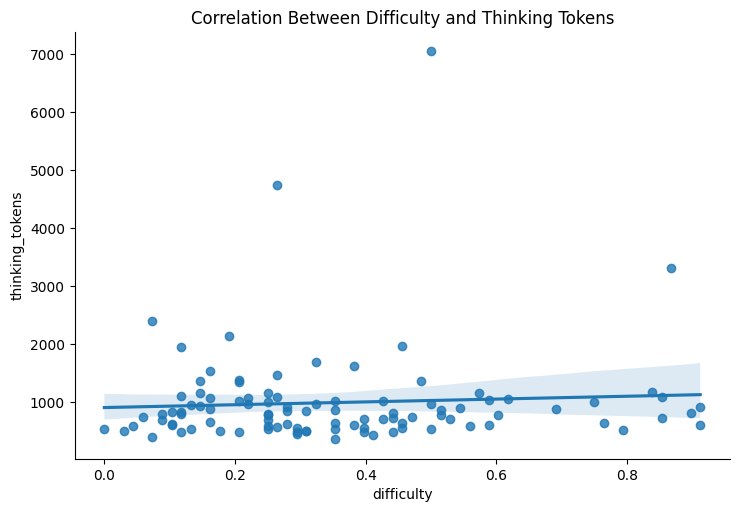

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute correlation
filtered_df = merged_df[merged_df['thinking_tokens'] <= 10000]
correlation = filtered_df[['difficulty', 'thinking_tokens']].corr()
print(correlation)

# Scatter plot with trendline
sns.lmplot(data=filtered_df, x='difficulty', y='thinking_tokens', aspect=1.5)
plt.title("Correlation Between Difficulty and Thinking Tokens")
plt.show()


                 difficulty  correct_numeric
difficulty          1.00000          0.00988
correct_numeric     0.00988          1.00000


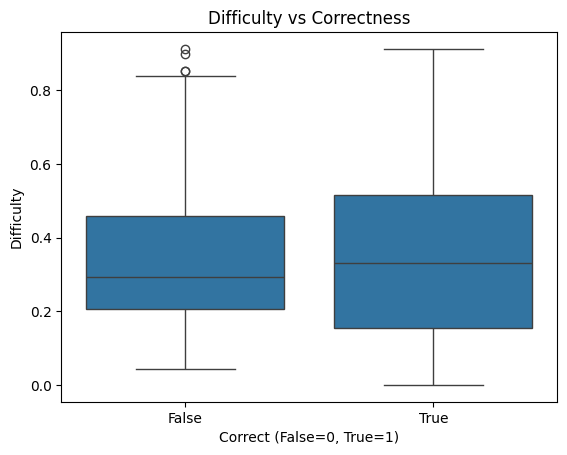

In [49]:
# Convert 'correct' column to numerical (False = 0, True = 1)
filtered_df['correct_numeric'] = filtered_df['correct'].astype(int)

# Compute correlation
correlation = filtered_df[['difficulty', 'correct_numeric']].corr()
print(correlation)

# Boxplot of difficulty vs correctness
sns.boxplot(data=filtered_df, x='correct', y='difficulty')
plt.title("Difficulty vs Correctness")
plt.xlabel("Correct (False=0, True=1)")
plt.ylabel("Difficulty")
plt.show()


### And let's run the non finetuned model with 2k token min

In [50]:
results = []
df = df.iloc[0:100]
# Create a dummy output stream
dummy_output = io.StringIO()

#with contextlib.redirect_stdout(dummy_output):
for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        question = row['question']
    
        response, num_think_tokens, num_swaps = reasoning_effort(question, "deepseek-r1:1.5b", min_thinking_tokens=2000) #min should be 2k now.
        #correct = (row["Answer_Text"].lower() in answer.lower())
        results.append({
            "question": question,
            "difficulty": row["Difficulty"],
            "thinking_tokens": num_think_tokens,
            "num_swaps": num_swaps,
            "response": response,
            # "reasoning_trace": thoughts
        })
    except Exception as e:
        raise(e)
        continue

with open('natural_think_time3.json', 'w') as f:
    json.dump(results, f)

100%|██████████| 100/100 [1:12:39<00:00, 43.60s/it]


In [51]:
print(len(results))

100


In [52]:
print(results[0])

{'question': 'A 27-year-old man comes to the emergency department because of a 3-hour history of pain around his navel. He also has had nausea and one episode of vomiting 1 hour ago. During the past year, he has had multiple episodes of dark stools, which last for 2 to 3 days and resolve spontaneously. He underwent an appendectomy 2 years ago. The patient says that his current symptoms are similar to those he had during the appendicitis episode. His temperature is 39.0Â°C (102.2Â°F), pulse is 94/min, respirations are 22/min, and blood pressure is 114/78 mm Hg. Pulse oximetry on room air shows an oxygen saturation of 99%. Physical examination shows rebound tenderness localized over the right lower quadrant. Results of laboratory studies are shown: Hemoglobin 12 g/dL Hematocrit 36% Leukocyte count 18,000/mm3 Platelet count 350,000/mm3 Serum Â\xa0 â€ƒUrea nitrogen 20 mg/dL â€ƒCreatinine 0.7 mg/dLCT scan of the abdomen shows fat stranding in the mesentery of the small bowel with an area of

In [53]:
results_df = pd.DataFrame(results)
results_df.to_csv('deepseek-r1-1.5-tok2000.csv')

In [54]:
def extract_answer(response_text):
    if "<answer>" in response_text:
        return response_text.split("<answer>")[-1].replace("</answer>", "")
    elif "Answer:" in response_text:
        return response_text.split("Answer:")[-1]
    elif "</think>" in response_text:
        return response_text.split("</think>")[-1]
    else:
        return response_text.split("\n\n")[-1]

In [55]:
results_df['cleaned_response'] = results_df['response'].apply(extract_answer)
df.rename(columns={'Formatted_Question': 'question'}, inplace=True)

# Merge df and results_df on the common key (adjust 'question_id' as needed)
merged_df = results_df.merge(df[['question', 'Answer_Key', 'Answer_Text']], on='question', how='left')

# Apply the logic row-wise
merged_df['correct'] = merged_df.apply(
    lambda row: (str(row['Answer_Key']) in str(row['cleaned_response'])) or 
                (str(row['Answer_Text']) in str(row['cleaned_response'])),
    axis=1
)


In [56]:
merged_df['response'].iloc[1]

"<think>\nHmm,Okay, I'm trying to figure out how to approach this question about the USMLE exam. So, let's break it down step by step.\n\nFirst, the patient presented with a\nAlternatively,6-month history of vaginal discharge that started as mild but has become foul-smelling and heavy. The clinical findings include normal margins in the supine position, no precipitate on the plane of the neck, and no visible mass near the cervix. Also, her blood pressure is\nWait,155/96 mmHg, which is a bit elevated for her age (32 kg/m²). She's married, had a\nAlternatively,4-year-old son after his death, has been without any new partners since then, and doesn't smoke or take medications.\n\nThe options given are A) Future fertility plans, B) Hypertension, C) Obesity, D) Patient age, E) Stage of disease. I need to determine the most critical factor for a management plan in this case.\n\nI remember that in U.S.MLE questions, factors like stage of disease, patient age, and hypertension are often key in 

In [57]:
merged_df.head(30)

,question,difficulty,thinking_tokens,num_swaps,response,cleaned_response,Answer_Key,Answer_Text,correct
0,A 27-year-old man comes to the emergency depar...,0.264706,989,19,"<think>\nWait,Okay, so I'm trying to figure ou...","\nAlternatively,>\nHmm,> A) Choristoma\nAltern...",D,Gastric mucosa,False
1,"A 39-year-old woman, gravida 2, para 2, comes ...",0.352941,667,12,"<think>\nHmm,Okay, I'm trying to figure out ho...","\nWait,> E) Stage of disease\nWait,\nAlternati...",E,Stage of disease,True
2,An 18-year-old primigravid woman comes for her...,0.411765,579,8,"<think>\nWait,Okay, so I'm trying to figure ou...","\nAlternatively,> B) Triple screening for MSAF...",C,Ultrasonography,True
3,"A 26-year-old man, who is admitted to the hosp...",0.397059,852,10,"<think>\nHmm,Okay, let me try to figure this o...","**\nWait,: D) Their sons will be at risk for a...",C,The sons of their daughters will be at risk fo...,False
4,A 60-year-old man had a total thyroidectomy an...,0.147059,915,15,"<think>\nAlternatively,Alright, I'm trying to ...","\nWait,> A\nWait,\nHmm,>\nHmm,",B,Chvostek sign,False
5,A 27-year-old man comes to the physician becau...,0.352941,666,22,"<think>\nHmm,Okay, let's try to figure out thi...","Hmm,\nWait,\nHmm,> { Bernard-Soulier syndrome ...",E,von Willebrand disease,False
6,A 55-year-old man has had crushing substernal ...,0.250000,489,14,"<think>\nAlternatively,Okay, so I'm trying to ...","Wait,\nAlternatively,\nWait,> {The treatment w...",A,Decreasing myocardial contractility,True
7,"In screening for prostate cancer, the current ...",0.455882,22716,43,"<think>\nHmm,Okay, so I'm trying to figure out...",To determine whether there is a relationship b...,G,â†“ â†‘,False
8,A 62-year-old man comes to the physician for a...,0.500000,884,8,"<think>\nAlternatively,Alright, let's try to f...","\nAlternatively,: D\nHmm,",E,â†“ â†‘ â†‘,False
9,"A 37-year-old woman, gravida 5, para 4, at 34 ...",0.250000,924,15,"<think>\nAlternatively,Okay, I'm trying to fig...","\nWait,> C\nHmm,\nAlternatively,>\nWait,",D,Placenta previa,False


In [58]:
merged_df.iloc[10]['response']

"<think>\nAlternatively,Okay, so I'm trying to figure out what's going on with this kid who's a\nHmm,2-year-old with some pretty concerning symptoms. Let me break it down step by step.\n\nFirst, the patient has failure of thrive (FOT), which is a clear sign that something is wrong because FOT usually points towards an underlying issue like disease or inflammation. The physical exam shows no other abnormalities, so I don't have any other signs to worry about. But the lab results are concerning too.\n\nThe labs show steatorrhea and a sweat chloride of\nAlternatively,80 mmol/L. Steatorrhea is a form of fluid retention, often seen in people with inflammatory conditions like Crohn's or ulcerative colitis. Sweat chloride being low (below\nWait,100 usually means it's not getting too acidic) suggests inflammation and fibrosis because normal values might be higher.\n\nThe physical examination doesn't find any other issues, so it's likely a bacterial infection. However, the x-ray shows hyperinfl

In [59]:
merged_df.iloc[10]

question            A 2-year-old boy is brought to the physician b...
difficulty                                                   0.279412
thinking_tokens                                                   790
num_swaps                                                          15
response            <think>\nAlternatively,Okay, so I'm trying to ...
cleaned_response    \nAlternatively,> D) Insulin\nAlternatively,\n...
Answer_Key                                                          A
Answer_Text                                               Bicarbonate
correct                                                          True
Name: 10, dtype: object

In [60]:
merged_df.correct.value_counts()

correct
False    67
True     33
Name: count, dtype: int64

                 difficulty  thinking_tokens
difficulty         1.000000         0.003736
thinking_tokens    0.003736         1.000000


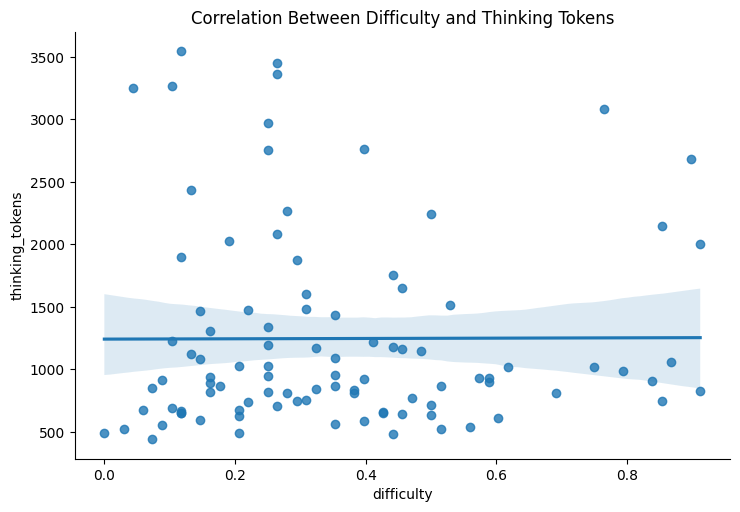

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute correlation
filtered_df = merged_df[merged_df['thinking_tokens'] <= 5000]
correlation = filtered_df[['difficulty', 'thinking_tokens']].corr()
print(correlation)

# Scatter plot with trendline
sns.lmplot(data=filtered_df, x='difficulty', y='thinking_tokens', aspect=1.5)
plt.title("Correlation Between Difficulty and Thinking Tokens")
plt.show()


C:\Users\ROHAN\AppData\Local\Temp\ipykernel_11940\3736686910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['correct_numeric'] = filtered_df['correct'].astype(int)


                 difficulty  correct_numeric
difficulty         1.000000        -0.105858
correct_numeric   -0.105858         1.000000


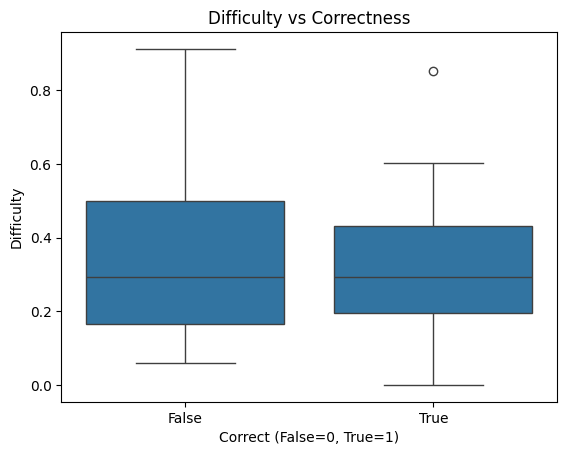

In [62]:
# Convert 'correct' column to numerical (False = 0, True = 1)
filtered_df['correct_numeric'] = filtered_df['correct'].astype(int)

# Compute correlation
correlation = filtered_df[['difficulty', 'correct_numeric']].corr()
print(correlation)

# Boxplot of difficulty vs correctness
sns.boxplot(data=filtered_df, x='correct', y='difficulty')
plt.title("Difficulty vs Correctness")
plt.xlabel("Correct (False=0, True=1)")
plt.ylabel("Difficulty")
plt.show()


### Token Distribution from training dataset vs usmle? How well does the medical reasoning set fit the USMLE set?

In [63]:
test_df = pd.read_csv('qa_data/BEA_2024_MCQ_DIFF.csv')
test_text = "\n".join(test_df['ItemStem_Text'].dropna().astype(str))
train_df = pd.read_json('qa_data/medical_o1_sft.json')
train_text = "\n".join(train_df['Question'].dropna().astype(str))

# Save to a text file
with open("train.txt", "w", encoding="utf-8") as f:
    f.write(train_text)

with open("test.txt", "w", encoding="utf-8") as f:
    f.write(test_text)

In [64]:
from tokenizers import Tokenizer
from collections import Counter
import re

tokenizer = Tokenizer.from_pretrained("bert-base-uncased")  # Example tokenizer

def count_tokens_hf(file_path):
    token_counts = Counter()
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            tokens = tokenizer.encode(line).tokens
            token_counts.update(tokens)
    return token_counts

train_counts = count_tokens_hf("train.txt")
test_counts = count_tokens_hf("test.txt")


c:\Users\ROHAN\anaconda3\envs\diffe\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
import numpy as np

def normalize_counter(counter):
    total = sum(counter.values())
    return {token: count / total for token, count in counter.items()}  # Convert to probability distribution

def align_distributions(train_counts, test_counts):
    """Aligns token distributions by adding missing tokens with small probability."""
    all_tokens = set(train_counts.keys()).union(set(test_counts.keys()))
    
    train_probs = np.array([train_counts.get(token, 1e-10) for token in all_tokens])
    test_probs = np.array([test_counts.get(token, 1e-10) for token in all_tokens])
    
    return train_probs, test_probs

In [66]:
from scipy.stats import entropy

def kl_divergence(p, q):
    p = np.array(p) + 1e-10  # Avoid division by zero
    q = np.array(q) + 1e-10
    return entropy(p, q) # KL(P || Q)


In [67]:
def js_divergence(train_probs, test_probs):
    m = 0.5 * (train_probs + test_probs)
    return 0.5 * entropy(train_probs, m) + 0.5 * entropy(test_probs, m)  # JSD


In [68]:
# Normalize to probabilities
train_probs_dict = normalize_counter(train_counts)
test_probs_dict = normalize_counter(test_counts)

# Align token distributions
train_probs, test_probs = align_distributions(train_probs_dict, test_probs_dict)

# Compute distances
kl_score = kl_divergence(train_probs, test_probs)
js_score = js_divergence(train_probs, test_probs)

print(f"KL Divergence: {kl_score:.4f}")
print(f"Jensen-Shannon Divergence: {js_score:.4f}")

KL Divergence: 1.4298
Jensen-Shannon Divergence: 0.1121


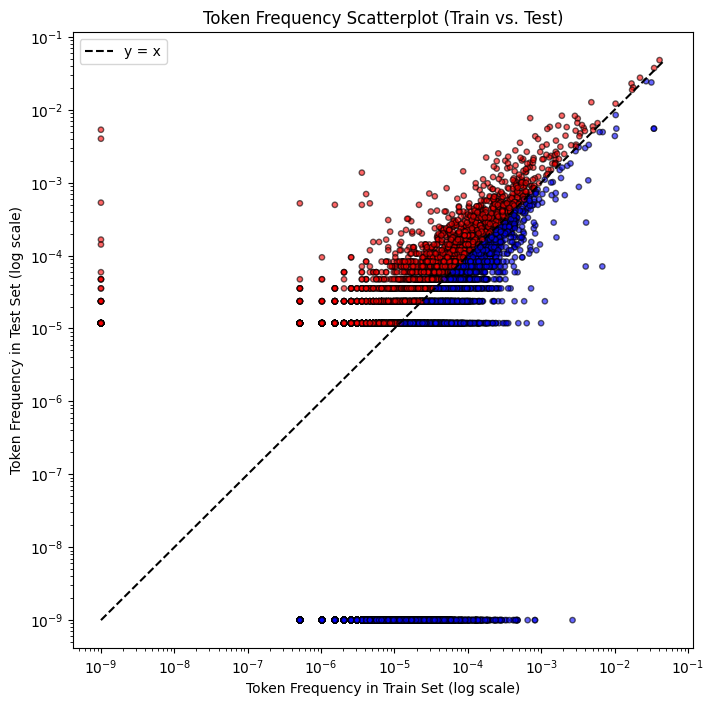

In [69]:
import matplotlib.pyplot as plt
import numpy as np

def plot_token_scatter(train_counts, test_counts):
    """Plots a scatterplot of token frequencies in train vs. test dataset."""

    # Normalize frequencies
    total_train_tokens = sum(train_counts.values())
    total_test_tokens = sum(test_counts.values())

    train_probs = {token: count / total_train_tokens for token, count in train_counts.items()}
    test_probs = {token: count / total_test_tokens for token, count in test_counts.items()}

    # Get union of tokens
    all_tokens = set(train_probs.keys()).union(set(test_probs.keys()))

    # Prepare scatterplot data
    train_freqs = np.array([train_probs.get(token, 1e-9) for token in all_tokens])  # Small value to avoid log(0)
    test_freqs = np.array([test_probs.get(token, 1e-9) for token in all_tokens])

    # Compute color mapping based on frequency ratio
    color_values = np.log1p(train_freqs) - np.log1p(test_freqs)  # log difference to see variation clearly
    colors = np.where(color_values > 0, "blue", np.where(color_values < 0, "red", "gray"))

    # Scatterplot
    plt.figure(figsize=(8, 8))
    plt.scatter(train_freqs, test_freqs, c=colors, alpha=0.6, edgecolors="k", s=15)

    # Log scale for better visualization
    plt.xscale("log")
    plt.yscale("log")

    # Add a diagonal reference line (y = x) manually
    min_freq = min(train_freqs.min(), test_freqs.min())
    max_freq = max(train_freqs.max(), test_freqs.max())
    plt.plot([min_freq, max_freq], [min_freq, max_freq], linestyle="dashed", color="black", label="y = x")

    plt.xlabel("Token Frequency in Train Set (log scale)")
    plt.ylabel("Token Frequency in Test Set (log scale)")
    plt.title("Token Frequency Scatterplot (Train vs. Test)")
    plt.legend()

    plt.show()

# Call the function with your token counts
plot_token_scatter(train_counts, test_counts)


#### 8B model

In [70]:
results = []
df = df.iloc[0:100]
# Create a dummy output stream
dummy_output = io.StringIO()

#with contextlib.redirect_stdout(dummy_output):
for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        question = row['question']
    
        response, num_think_tokens, num_swaps = reasoning_effort(question, "deepseek-r1:8b", min_thinking_tokens=0) #min should be 2k now.
        #correct = (row["Answer_Text"].lower() in answer.lower())
        results.append({
            "question": question,
            "difficulty": row["Difficulty"],
            "thinking_tokens": num_think_tokens,
            "num_swaps": num_swaps,
            "response": response,
            # "reasoning_trace": thoughts
        })
    except Exception as e:
        raise(e)
        continue

with open('natural_think_time3.json', 'w') as f:
    json.dump(results, f)

100%|██████████| 100/100 [13:38:07<00:00, 490.88s/it] 


In [71]:
print(len(results))

100


In [72]:
print(results[0])

{'question': 'A 27-year-old man comes to the emergency department because of a 3-hour history of pain around his navel. He also has had nausea and one episode of vomiting 1 hour ago. During the past year, he has had multiple episodes of dark stools, which last for 2 to 3 days and resolve spontaneously. He underwent an appendectomy 2 years ago. The patient says that his current symptoms are similar to those he had during the appendicitis episode. His temperature is 39.0Â°C (102.2Â°F), pulse is 94/min, respirations are 22/min, and blood pressure is 114/78 mm Hg. Pulse oximetry on room air shows an oxygen saturation of 99%. Physical examination shows rebound tenderness localized over the right lower quadrant. Results of laboratory studies are shown: Hemoglobin 12 g/dL Hematocrit 36% Leukocyte count 18,000/mm3 Platelet count 350,000/mm3 Serum Â\xa0 â€ƒUrea nitrogen 20 mg/dL â€ƒCreatinine 0.7 mg/dLCT scan of the abdomen shows fat stranding in the mesentery of the small bowel with an area of

In [73]:
results_df = pd.DataFrame(results)
results_df.to_csv('ubitquitin_medical_deepseek-8-tok0.csv')

In [74]:
def extract_answer(response_text):
    if "<answer>" in response_text:
        return response_text.split("<answer>")[-1].replace("</answer>", "")
    elif "Answer:" in response_text:
        return response_text.split("Answer:")[-1]
    elif "</think>" in response_text:
        return response_text.split("</think>")[-1]
    else:
        return response_text.split("\n\n")[-1]

In [75]:
results_df['cleaned_response'] = results_df['response'].apply(extract_answer)
df.rename(columns={'Formatted_Question': 'question'}, inplace=True)

# Merge df and results_df on the common key (adjust 'question_id' as needed)
merged_df = results_df.merge(df[['question', 'Answer_Key', 'Answer_Text']], on='question', how='left')

# Apply the logic row-wise
merged_df['correct'] = merged_df.apply(
    lambda row: (str(row['Answer_Key']) in str(row['cleaned_response'])) or 
                (str(row['Answer_Text']) in str(row['cleaned_response'])),
    axis=1
)


In [76]:
merged_df['response'].iloc[1]

'<think>Okay, so I have this clinical case to analyze. Let me read through it again carefully.\n\nThe patient is a39-year-old woman with a history of being gravida2 and para2. She\'s presenting because of a6-month history of copious, foul-smelling vaginal discharge. She also mentions spotting that started six months ago and has recently become heavy bleeding over the past three weeks. Her medical history includes an abnormal Pap smear in her twenties, but her most recent Pap was done during her second pregnancy twelve years ago and was normal. She doesn\'t take any medications. She\'s been married for16 years, but her husband died four years ago after a vasectomy following their last child. She hasn\'t had any new sexual partners since then. Her BMI is32 kg/m², so she\'s considered obese. Vital signs show a temperature of37.2°C (slightly elevated), pulse90/min, respirations14/min, and blood pressure of155/96 mmHg, indicating she has hypertension.\n\nOn examination, the vaginal mucosa l

In [77]:
merged_df.head(30)

,question,difficulty,thinking_tokens,num_swaps,response,cleaned_response,Answer_Key,Answer_Text,correct
0,A 27-year-old man comes to the emergency depar...,0.264706,3154,0,"<think>Okay, so I've got a27-year-old man pres...",C) Endothelial cells**,D,Gastric mucosa,False
1,"A 39-year-old woman, gravida 2, para 2, comes ...",0.352941,1069,0,"<think>Okay, so I have this clinical case to a...",The most critical factor in formulating the ma...,E,Stage of disease,True
2,An 18-year-old primigravid woman comes for her...,0.411765,1302,0,"<think>Okay, so I have this question about pre...",The most appropriate next step in management f...,C,Ultrasonography,True
3,"A 26-year-old man, who is admitted to the hosp...",0.397059,1145,0,"<think>Okay, so I have this medical case to so...",E) Their sons and daughters will be at risk f...,C,The sons of their daughters will be at risk fo...,False
4,A 60-year-old man had a total thyroidectomy an...,0.147059,1131,0,"<think>Okay, so I'm trying to figure out this ...",**\nB) Chvostek sign,B,Chvostek sign,True
5,A 27-year-old man comes to the physician becau...,0.352941,2223,0,"<think>Okay, so I have this case here, and I n...",The patient presents with a combination of sym...,E,von Willebrand disease,False
6,A 55-year-old man has had crushing substernal ...,0.250000,2156,0,"<think>Okay, so I have this medical question h...",** A) Decreasing myocardial contractility.,A,Decreasing myocardial contractility,True
7,"In screening for prostate cancer, the current ...",0.455882,5116,0,"<think>Okay, so I'm trying to figure out this ...",** The effect varies; PPV may increase or decr...,G,â†“ â†‘,False
8,A 62-year-old man comes to the physician for a...,0.500000,4214,0,"<think>Okay, so I have this question about a p...",The correct answer is:\n\n**A: ↓↓↓**\n\nThis i...,E,â†“ â†‘ â†‘,False
9,"A 37-year-old woman, gravida 5, para 4, at 34 ...",0.250000,2009,0,"<think>Alright, let me try to work through thi...",The most likely diagnosis based on the provide...,D,Placenta previa,False


In [78]:
merged_df.iloc[10]['response']

'<think>Okay, so I have this question about a2-year-old boy who\'s brought in because he\'s failing to thrive. He also has loose, fatty, foul-smelling stools and a cough for the past two weeks. His height is at the30th percentile and weight at the10th percentile, which suggests he\'s not growing as expected and maybe not getting enough nutrients.\n\nThe physical exam doesn\'t show any other issues apart from what\'s given. The lab results show steatorrhea, which means he\'s having fatty, oily stools. Steatorrhea often points towards malabsorption because the body isn\'t absorbing fat properly. There\'s also a sweat chloride concentration of80 mmol/L. Wait, elevated sweat chloride is typically seen in cystic fibrosis, right? Because in CF, the sweat glands don\'t work properly and let more chloride out. So this could be a clue towards CF.\n\nThe chest x-ray shows hyperinflation. Hyperinflation in the lungs can happen with COPD or other chronic lung conditions, but in children, it\'s oft

In [79]:
merged_df.iloc[10]

question            A 2-year-old boy is brought to the physician b...
difficulty                                                   0.279412
thinking_tokens                                                  2862
num_swaps                                                           0
response            <think>Okay, so I have this question about a2-...
cleaned_response                                        ** D) Insulin
Answer_Key                                                          A
Answer_Text                                               Bicarbonate
correct                                                         False
Name: 10, dtype: object

In [80]:
merged_df.correct.value_counts()

correct
True     59
False    41
Name: count, dtype: int64

                 difficulty  thinking_tokens
difficulty         1.000000         0.156454
thinking_tokens    0.156454         1.000000


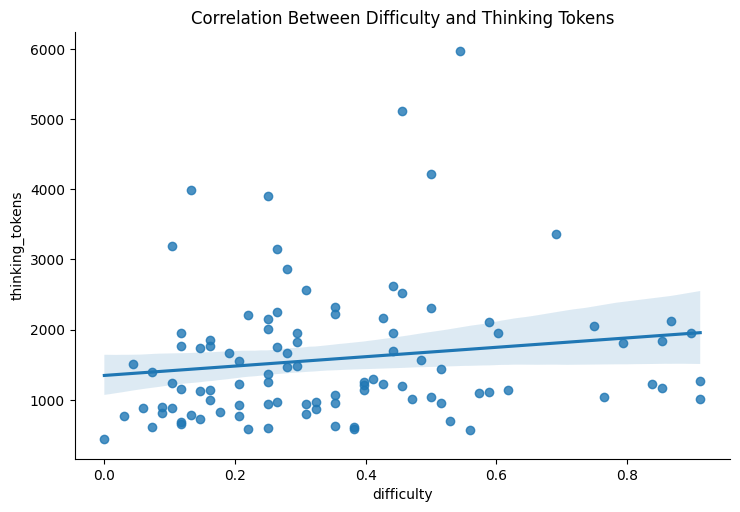

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute correlation
filtered_df = merged_df[merged_df['thinking_tokens'] <= 32000]
correlation = filtered_df[['difficulty', 'thinking_tokens']].corr()
print(correlation)

# Scatter plot with trendline
sns.lmplot(data=filtered_df, x='difficulty', y='thinking_tokens', aspect=1.5)
plt.title("Correlation Between Difficulty and Thinking Tokens")
plt.show()


C:\Users\ROHAN\AppData\Local\Temp\ipykernel_11940\3736686910.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['correct_numeric'] = filtered_df['correct'].astype(int)


                 difficulty  correct_numeric
difficulty         1.000000        -0.323688
correct_numeric   -0.323688         1.000000


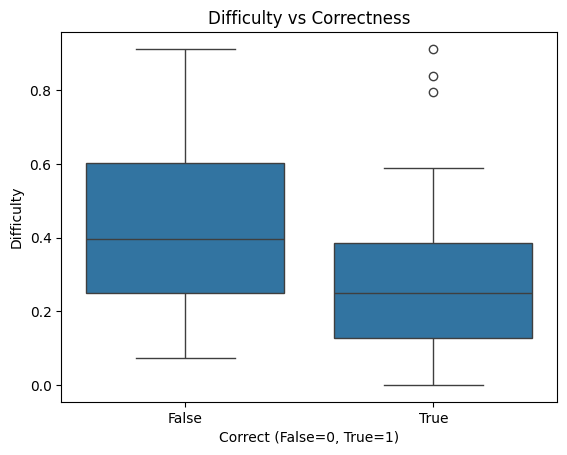

In [82]:
# Convert 'correct' column to numerical (False = 0, True = 1)
filtered_df['correct_numeric'] = filtered_df['correct'].astype(int)

# Compute correlation
correlation = filtered_df[['difficulty', 'correct_numeric']].corr()
print(correlation)

# Boxplot of difficulty vs correctness
sns.boxplot(data=filtered_df, x='correct', y='difficulty')
plt.title("Difficulty vs Correctness")
plt.xlabel("Correct (False=0, True=1)")
plt.ylabel("Difficulty")
plt.show()


### Finetuned 8b model 0tok

In [10]:
import io
from r1_overthink import reasoning_effort

In [11]:
results = []
df = df.iloc[0:100]
# Create a dummy output stream
dummy_output = io.StringIO()

#with contextlib.redirect_stdout(dummy_output):
for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        question = row['question']
    
        response, num_think_tokens, num_swaps = reasoning_effort(question, "hf.co/ubiqtuitin/deepseek_r1_8b_medical-ft_q4_k_m", min_thinking_tokens=0) #min should be 2k now.
        #correct = (row["Answer_Text"].lower() in answer.lower())
        results.append({
            "question": question,
            "difficulty": row["Difficulty"],
            "thinking_tokens": num_think_tokens,
            "num_swaps": num_swaps,
            "response": response,
            # "reasoning_trace": thoughts
        })
    except Exception as e:
        raise(e)
        continue

with open('natural_think_time3.json', 'w') as f:
    json.dump(results, f)

100%|██████████| 100/100 [14:12:15<00:00, 511.35s/it]  


NameError: name 'json' is not defined

In [12]:
print(len(results))

100


In [13]:
print(results[0])

{'question': 'A 27-year-old man comes to the emergency department because of a 3-hour history of pain around his navel. He also has had nausea and one episode of vomiting 1 hour ago. During the past year, he has had multiple episodes of dark stools, which last for 2 to 3 days and resolve spontaneously. He underwent an appendectomy 2 years ago. The patient says that his current symptoms are similar to those he had during the appendicitis episode. His temperature is 39.0Â°C (102.2Â°F), pulse is 94/min, respirations are 22/min, and blood pressure is 114/78 mm Hg. Pulse oximetry on room air shows an oxygen saturation of 99%. Physical examination shows rebound tenderness localized over the right lower quadrant. Results of laboratory studies are shown: Hemoglobin 12 g/dL Hematocrit 36% Leukocyte count 18,000/mm3 Platelet count 350,000/mm3 Serum Â\xa0 â€ƒUrea nitrogen 20 mg/dL â€ƒCreatinine 0.7 mg/dLCT scan of the abdomen shows fat stranding in the mesentery of the small bowel with an area of

In [14]:
results_df = pd.DataFrame(results)
results_df.to_csv('ubitquitin_medical_deepseek-8-tok0.csv')

In [15]:
def extract_answer(response_text):
    if "<answer>" in response_text:
        return response_text.split("<answer>")[-1].replace("</answer>", "")
    elif "Answer:" in response_text:
        return response_text.split("Answer:")[-1]
    elif "</think>" in response_text:
        return response_text.split("</think>")[-1]
    else:
        return response_text.split("\n\n")[-1]

In [16]:
results_df['cleaned_response'] = results_df['response'].apply(extract_answer)
df.rename(columns={'Formatted_Question': 'question'}, inplace=True)

# Merge df and results_df on the common key (adjust 'question_id' as needed)
merged_df = results_df.merge(df[['question', 'Answer_Key', 'Answer_Text']], on='question', how='left')

# Apply the logic row-wise
merged_df['correct'] = merged_df.apply(
    lambda row: (str(row['Answer_Key']) in str(row['cleaned_response'])) or 
                (str(row['Answer_Text']) in str(row['cleaned_response'])),
    axis=1
)


In [17]:
merged_df['response'].iloc[1]

"<think>Okay, so I'm trying to figure out what's the best answer for this medical question. Let me start by reading it carefully again and thinking through all the details.\n\nWe have a39-year-old woman who is gravida2 with para2 status. She has had a history of copious, foul-smelling vaginal discharge for six months and also mentions spotting that started six months ago, which has become heavy bleeding in the last three weeks. Her medical history shows an abnormal Pap smear when she was in her twenties, but her recent Pap smear from twelve years ago during pregnancy was normal.\n\nShe's not on any medications. She's married for16 years, and her husband died four years ago after a vasectomy. It's noted that since the death of her husband, she hasn't had any new sexual partners. Her BMI is32 kg/m², so she's considered overweight.\n\nVital signs show she has a fever:37.2°C (99°F), elevated pulse at90/min, and respiratory rate at14/min. Blood pressure is155/96 mmHg, which means she has hy

In [18]:
merged_df.head(30)

,question,difficulty,thinking_tokens,num_swaps,response,cleaned_response,Answer_Key,Answer_Text,correct
0,A 27-year-old man comes to the emergency depar...,0.264706,3453,0,"<think>Okay, so let's think about this case. W...",**\nE) Striated Muscle,D,Gastric mucosa,False
1,"A 39-year-old woman, gravida 2, para 2, comes ...",0.352941,951,0,"<think>Okay, so I'm trying to figure out what'...",E) Stage of disease,E,Stage of disease,True
2,An 18-year-old primigravid woman comes for her...,0.411765,1222,0,"<think>Okay, so I've got this question here ab...",The appropriate next step in management is:\n\...,C,Ultrasonography,True
3,"A 26-year-old man, who is admitted to the hosp...",0.397059,2759,0,"<think>Okay, let me try to figure this out. So...","Yes, if the father is an unaffected male with ...",C,The sons of their daughters will be at risk fo...,False
4,A 60-year-old man had a total thyroidectomy an...,0.147059,1464,0,"<think>Okay, let's think through this scenario...","Based on the provided information, the most li...",B,Chvostek sign,True
5,A 27-year-old man comes to the physician becau...,0.352941,863,0,"<think>Alright, let's figure out this medical ...",The most likely diagnosis for this patient is ...,E,von Willebrand disease,True
6,A 55-year-old man has had crushing substernal ...,0.250000,1196,0,"<think>Alright, let me try to figure this out....",The most appropriate answer to improve the pat...,A,Decreasing myocardial contractility,False
7,"In screening for prostate cancer, the current ...",0.455882,1161,0,"<think>Okay, so I have this question about pro...",B) ↓ no change,G,â†“ â†‘,False
8,A 62-year-old man comes to the physician for a...,0.500000,710,0,"<think>Alright, so I'm trying to figure out wh...",The biopsy specimen most likely shows an incre...,E,â†“ â†‘ â†‘,False
9,"A 37-year-old woman, gravida 5, para 4, at 34 ...",0.250000,1023,0,"<think>Okay, let's think about this case. We h...",** A) Abruptio placentae,D,Placenta previa,False


In [19]:
merged_df.iloc[10]['response']

'<think>Okay, so let\'s take a look at this case. We have a2-year-old boy with failure to thrive and some other symptoms like loose stools, foul-smelling they\'re called fatty stools, and he also has a cough for about two weeks now. The doctors are worried about something serious because these could be signs of an infection or maybe something chronic.\n\nFirst off, he\'s on the lower end for height and even more so for weight—30th percentile for height and10th for weight. That makes me think there might be some nutritional issues going on here, like malnutrition, but it\'s also possible there\'s a more serious underlying condition affecting his growth.\n\nNow, let\'s think about the physical exam. It says he has no other abnormalities mentioned, so we don\'t have to worry about obvious things like broken bones or infections in other areas, just these gastrointestinal symptoms and his overall weight gain problems.\n\nThe lab results are showing steatorrhea—that means there\'s fat in his

In [20]:
merged_df.iloc[10]

question            A 2-year-old boy is brought to the physician b...
difficulty                                                   0.279412
thinking_tokens                                                  5938
num_swaps                                                           0
response            <think>Okay, so let's take a look at this case...
cleaned_response    ** The decrease in intrinsic factors in a2-yea...
Answer_Key                                                          A
Answer_Text                                               Bicarbonate
correct                                                         False
Name: 10, dtype: object

In [21]:
merged_df.correct.value_counts()

correct
True     60
False    40
Name: count, dtype: int64

                 difficulty  thinking_tokens
difficulty         1.000000         0.009573
thinking_tokens    0.009573         1.000000


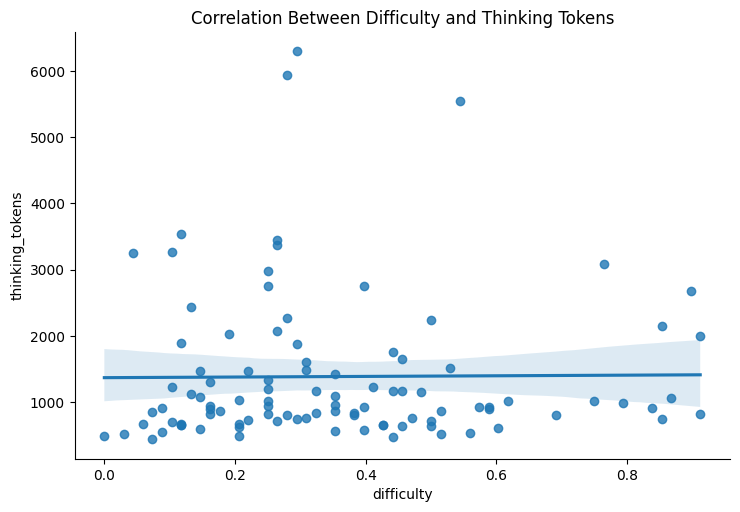

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute correlation
filtered_df = merged_df[merged_df['thinking_tokens'] <= 32000]
correlation = filtered_df[['difficulty', 'thinking_tokens']].corr()
print(correlation)

# Scatter plot with trendline
sns.lmplot(data=filtered_df, x='difficulty', y='thinking_tokens', aspect=1.5)
plt.title("Correlation Between Difficulty and Thinking Tokens")
plt.show()


                 difficulty  correct_numeric
difficulty         1.000000        -0.105306
correct_numeric   -0.105306         1.000000


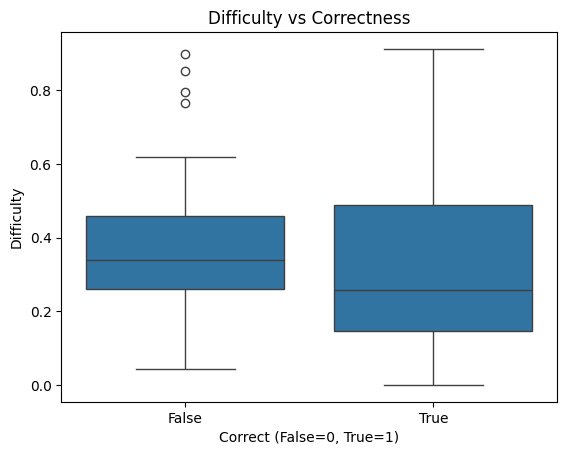

In [23]:
# Convert 'correct' column to numerical (False = 0, True = 1)
filtered_df['correct_numeric'] = filtered_df['correct'].astype(int)

# Compute correlation
correlation = filtered_df[['difficulty', 'correct_numeric']].corr()
print(correlation)

# Boxplot of difficulty vs correctness
sns.boxplot(data=filtered_df, x='correct', y='difficulty')
plt.title("Difficulty vs Correctness")
plt.xlabel("Correct (False=0, True=1)")
plt.ylabel("Difficulty")
plt.show()
